# Steps in order
1. Create and fit_transform polynomial of desired degree (sklearn.preprocessing -> PolynomialFeatures)
2. Perform train_test_split (sklearn.model_selection -> train_test_split)
3. Create a scaler and fit on train set (never fit on test set to prevent information leakage and then transform to desired set to scale them (sklearn.preprocessing -> StandardScaler)
4. train the model, tune the parameters for best best performing model
5. deploy the model

In [1]:
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('Advertising.csv').drop('Unnamed: 0', axis =1)

In [3]:
X = df.drop('sales', axis = 1)
y = df[['sales']]

In [4]:
# poly_converter needs to be saved
poly_converter = PolynomialFeatures(degree=3, include_bias = False)

In [5]:
polyfeatures = poly_converter.fit_transform(X)

In [6]:
# perform train_test_split on all the features after polynomial conversion
X_train, X_test, y_train, y_test = train_test_split(polyfeatures, y, test_size=0.3, random_state=101)

In [7]:
# fit and transform only on train data during scaling to prevent information leakage
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

- while we fit scaler, the set with which we fit, it calculates the mean and variance from that set.
- we generally fit with X_train and later transform with desired set (train and test) to scale them using the mean and variance of the training set

In [8]:
scaled_X_train = scaler.transform(X_train)

In [9]:
scaled_X_test = scaler.transform(X_test)

In [10]:
# mean of each features from X_train (here 19 features)
scaler.mean_

array([1.51660714e+02, 2.34121429e+01, 3.11057143e+01, 3.01003648e+04,
       3.63985693e+03, 4.93311614e+03, 7.65516786e+02, 8.26798214e+02,
       1.42591571e+03, 6.63869070e+06, 7.33083952e+05, 1.02082306e+06,
       1.19094013e+05, 1.32772145e+05, 2.36790577e+05, 2.82374318e+04,
       2.87100148e+04, 4.20677281e+04, 8.08470770e+04])

In [11]:
# variance of each features from X_train (here 19 features)
scaler.var_

array([7.09939253e+03, 2.17388353e+02, 4.58350253e+02, 6.47022039e+08,
       1.09433348e+07, 2.68796667e+07, 5.23266484e+05, 8.41185477e+05,
       3.20831322e+06, 5.05298545e+13, 7.36667249e+11, 1.98814711e+12,
       2.10675849e+10, 3.69109908e+10, 1.61189347e+11, 1.10868369e+09,
       1.56234026e+09, 4.66468302e+09, 2.18769129e+10])

# Ridge Regression (L2 Regularization)

In [12]:
from sklearn.linear_model import Ridge

In [13]:
# In Ridge alpha is actually the lambda parameter
# it is because the in scikit-learn every tunable parameter is named alpha
model = Ridge(alpha = 10)

In [14]:
model.fit(scaled_X_train, y_train)

Ridge(alpha=10)

In [15]:
test_predict = model.predict(scaled_X_test)

In [16]:
test_residuals = y_test - test_predict

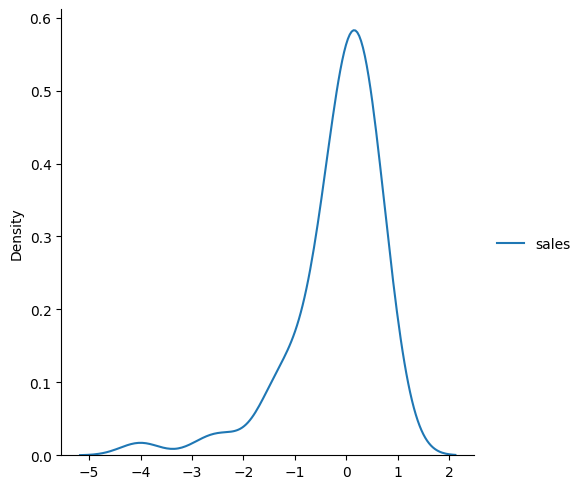

In [17]:
sns.displot(test_residuals, kind = 'kde');

In [18]:
MSE = (test_residuals**2).mean()
RMSE = np.sqrt(MSE)

In [19]:
RMSE

sales    0.894639
dtype: float64

- Here, when alpha is 10, the model performed poorly. So what value of alpha is appropriate?
- In `Ridge` model, it is difficult to tune the alpha parameter because it only accepts single value for alpha
- there's a `RidgeCV` model in scikit learn's linear_model which perfroms ridge regression on multiple alpha parameter and returns the model with best alpha.
- `model.alpha_` shows the best performing alpha
- If `cv` parameter in `RidgeCV` is not defined it'll perform leave-one-out cross-validation else when value is provided it performs k-fold cross-validation based on the value

In [20]:
from sklearn.linear_model import RidgeCV

In [21]:
ridgecv_model = RidgeCV(alphas= (0.1, 0.01, 0.001, 1, 1.2))

In [22]:
ridgecv_model.fit(scaled_X_train, y_train)

RidgeCV(alphas=(0.1, 0.01, 0.001, 1, 1.2))

In [23]:
ridgecv_model.alpha_

np.float64(0.01)

In [24]:
predict_test = ridgecv_model.predict(scaled_X_test)

In [25]:
residuals_test = y_test - predict_test

In [26]:
test_MSE = (residuals_test**2).mean()

In [27]:
test_RMSE = np.sqrt(test_MSE)

In [28]:
test_RMSE, test_MSE

(sales    0.582961
 dtype: float64,
 sales    0.339844
 dtype: float64)

In [29]:
predict_train = ridgecv_model.predict(scaled_X_train)
residuals_train = y_train - predict_train
train_MSE = (residuals_train**2).mean()
train_RMSE = np.sqrt(train_MSE)
train_RMSE, train_MSE

(sales    0.434811
 dtype: float64,
 sales    0.189061
 dtype: float64)

In [30]:
from sklearn.metrics import r2_score
r2_score(predict_test, y_test) , r2_score(predict_train, y_train)

(0.9878153433591097, 0.9927558915322389)

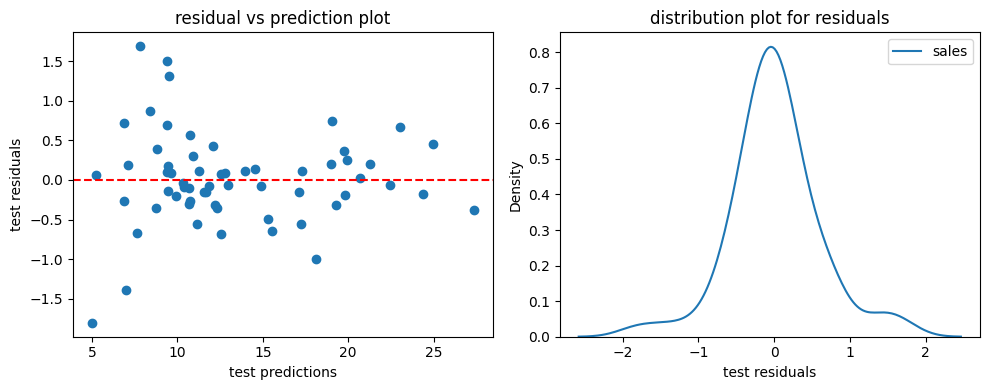

In [31]:
fig, ax = plt.subplots(1,2,figsize= (10,4))
sns.kdeplot(residuals_test);
ax[1].set_xlabel('test residuals')
ax[0].scatter(predict_test, residuals_test)
ax[0].axhline(y=0, ls = '--', c= 'red')
ax[0].set_xlabel('test predictions')
ax[0].set_ylabel('test residuals')
ax[0].set_title('residual vs prediction plot')
ax[1].set_title('distribution plot for residuals')
plt.tight_layout()

In [32]:
campaign = [[100,200,50]]
campaign_X = poly_converter.fit_transform(campaign)
scaled_campaign = scaler.fit_transform(campaign_X)

In [33]:
ridgecv_model.predict(scaled_campaign)

array([[14.31142857]])

# CHECK HERE
- The prediction for the campaign as compared to non-ridge linear regression is dramatically low with other constraints being all good and model is appropriate.
> Yet to understand that which model is predicting correctly

    - see Bias-variance tradeoff: the polynomial regression with degree 3 (same as here) but no ridge applied is predicting sales to be 59.545, here it is 14.311

In [34]:
polyfeature_columns = poly_converter.get_feature_names_out(['TV', 'radio', 'newspaper'])

In [35]:
# plotting all 19 features to see how prediction is fitting with target variable 
# X_test_df = pd.DataFrame(data = scaled_X_test, columns=polyfeature_columns)
# fig, ax = plt.subplots(7,3, figsize= (10,15))
# for index, features in enumerate(X_test_df):
#     ax[index//3, index%3].scatter(X_test_df[features], y_test, s = 10)
#     ax[index//3, index%3].set_xlabel(polyfeature_columns[index])
#     ax[index//3 ,index%3].set_ylabel('sales')
#     ax[index//3, index%3].scatter(X_test_df[features], test_predict, c='red', s=5)
    
# plt.delaxes(ax[6,1])
# plt.delaxes(ax[6,2])
# fig.tight_layout();

In [36]:
ridgecv_model.coef_

array([[ 6.9038259 ,  0.49047734,  0.29464737, -9.7103904 ,  5.06456503,
        -1.66613758, -1.30427348,  0.76860722,  0.35722042,  4.58992377,
        -1.52624141,  1.42375451,  0.43356846, -0.31710017,  0.03883517,
         0.71412093, -0.3097189 , -0.21689709, -0.24610412]])

In [37]:
model.coef_

array([[ 2.11063462,  0.62207087,  0.06822351,  0.20543482,  1.83561135,
         0.33399306,  0.02544162,  0.15472622, -0.02220834, -0.62586462,
         0.41216201, -0.49628796,  1.11873234,  0.24222164, -0.00821273,
        -0.20160416, -0.14825878, -0.06688285, -0.06004278]])

In [38]:
# best performing alpha for ridge regression
ridgecv_model.alpha_

np.float64(0.01)

# Lasso Regression (L1 Regualrization)
- In scikit-learn there are several models for lasso regression, some of them are
    - Lasso
    - LassoCV (lasso with cross-validation)
    - LassoLarsCV (based on Least angle regression algorithm)
    - LassoLarsIC (based on Akaike information criterion (AIC) and the Bayes Information criterion (BIC))
> We generally use LassoCV but incase note that there exist variants of Lasso Regression

In [39]:
from sklearn.linear_model import LassoCV

In [40]:
lassocv_model = LassoCV(eps=0.001, n_alphas = 100, cv=5, max_iter = 10000)

In LassoCV
- eps is length of the path. default is eps=1e-3 means that $\alpha_{min} \div \alpha_{max}$ = 1e-3.
- Specifies the number of $\alpha$ values to test during cross-validation, default = 100
- the `eps` and `n_alphas` together create a list of alphas that will be used to perform linear regression with L1 regularization.
- the list of alphas ranges from $\alpha_{min}\ to\ \alpha_{max}$
- a list of alphas is generated as
- `alphas = np.logspace(np.log10(alpha_max), np.log10(alpha_max * eps), num=n_alphas)`
- The higher the `n_aphas` the more search for best performing alpha
- if not provided `cv` in the LassoCV, default is $cv = 5$
- `max_iter` is set 1000 default, this might sometimes not be enough to converge the gradient descent resulting `Object did not converge` warnings. In such case it might be helpful to increase the `max_iter` and check again 
- OR, we can keep `max_iter` the default and increase the value for `eps`
- Both are appropriate rather it is a tradeoff between the computation time and model performace.
- low `eps` allows the wide range of 

In [41]:
scaled_X_test.shape, y_test.shape

((60, 19), (60, 1))

In [42]:
lassocv_model.fit(scaled_X_train, y_train)

/home/sid/sid/machineLearning/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LassoCV(cv=5, max_iter=10000)

In [43]:
test_predict = lassocv_model.predict(scaled_X_test)
train_predict = lassocv_model.predict(scaled_X_train)

In [44]:
lassocv_model.alpha_

np.float64(0.004943070909225831)

In [45]:
test_predict

array([14.16203485, 19.2942685 , 12.34178429, 16.97745571,  8.02340978,
        6.95799942, 20.11875833, 17.32880647, 10.43139937, 19.96174466,
        9.56959473, 13.94205676, 11.90851817, 23.35138146, 19.56656277,
        9.27838151, 12.30485359,  9.30152997,  8.56733436, 21.51633564,
        7.06650884, 19.3377222 , 27.28027149, 24.52239173,  9.17172464,
       11.60918126, 20.73841405,  9.29953525, 12.56948515,  8.40051066,
        8.56984613, 20.03587647, 10.83439653,  6.79505173, 18.18820331,
        9.48107219, 10.41803957,  9.70785725,  7.22932328, 10.85467692,
       12.85491418, 10.51648453, 11.26905127,  7.41516944, 11.54705407,
       10.42233031,  6.02782344, 15.36338733, 13.18723611, 22.67619584,
       10.4721906 , 13.01165791, 14.56684361, 11.90062303, 11.47303307,
        5.59404766, 25.06115365,  9.69468957, 17.44771723, 15.60375637])

In [46]:
test_predict = test_predict.reshape((test_predict.size, 1))
train_predict = train_predict.reshape((train_predict.size,1))
test_predict.shape, train_predict.shape

((60, 1), (140, 1))

In [47]:
test_residuals = y_test - test_predict
train_residuals = y_train - train_predict

In [48]:
test_MSE = (test_residuals**2).mean()
test_RMSE = np.sqrt(test_MSE)

train_MSE = (train_residuals**2).mean()
train_RMSE = np.sqrt(train_MSE)

In [49]:
[test_MSE, test_RMSE], [train_MSE, train_RMSE]

([sales    0.367617
  dtype: float64,
  sales    0.606314
  dtype: float64],
 [sales    0.265606
  dtype: float64,
  sales    0.51537
  dtype: float64])

<Axes: ylabel='Density'>

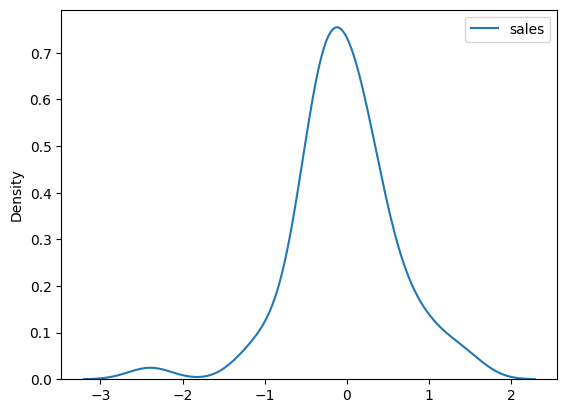

In [50]:
sns.kdeplot(test_residuals)

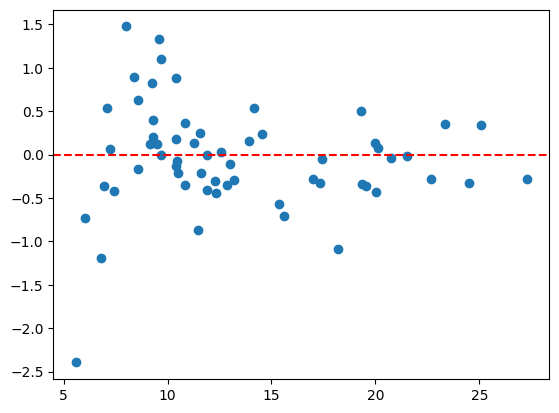

In [51]:
plt.scatter(test_predict, test_residuals)
plt.axhline(y=0 ,ls ='--', c='red')

In [52]:
campaign = [[100,200,50]]
campaign_X = poly_converter.fit_transform(campaign)
scaled_campaign = scaler.fit_transform(campaign_X)

In [53]:
lassocv_model.predict(scaled_campaign)

array([14.31142857])

- as I'm doing same campaign test for all the models I tried
- the linear regression and polynomial regression were pretty worse in prediction
- But the Ridge and Lasso are performing equally good and the prediction for the campaign is equal to the 8th decimal places
- the residual's normality is a bit left skewed but if we see the model's coefficients it is considering most of them zero and yet able to perform as much as Ridge.
- we can always tradeoff between the `eps` and `max_iter` in LassoCV to check things around and train model well for test data

In [54]:
lassocv_model.coef_

array([ 4.86023329,  0.12544598,  0.20746872, -4.99250395,  4.38026519,
       -0.22977201, -0.        ,  0.07267717, -0.        ,  1.77780246,
       -0.69614918, -0.        ,  0.12044132, -0.        , -0.        ,
       -0.        ,  0.        ,  0.        , -0.        ])

In [55]:
poly_converter.get_feature_names_out(['Tv', 'radio', 'newspaper'])

array(['Tv', 'radio', 'newspaper', 'Tv^2', 'Tv radio', 'Tv newspaper',
       'radio^2', 'radio newspaper', 'newspaper^2', 'Tv^3', 'Tv^2 radio',
       'Tv^2 newspaper', 'Tv radio^2', 'Tv radio newspaper',
       'Tv newspaper^2', 'radio^3', 'radio^2 newspaper',
       'radio newspaper^2', 'newspaper^3'], dtype=object)

- The model coefficient's complexity in lasso is down to 5, while Ridge was considering all 19 coefficients for prediction 

# Elastic Net Regualrization

In [56]:
from sklearn.linear_model import ElasticNetCV

In [57]:
elastic_model = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], eps = 0.001, n_alphas= 100, cv = 5, max_iter = 10000)

In [58]:
elastic_model.fit(scaled_X_train, y_train)

/home/sid/sid/machineLearning/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ElasticNetCV(cv=5, l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1], max_iter=10000)

In [59]:
test_predict = elastic_model.predict(scaled_X_test)
train_predict = elastic_model.predict(scaled_X_train)

In [60]:
test_predict = test_predict.reshape((test_predict.size, 1))
train_predict = train_predict.reshape((train_predict.size, 1))

In [61]:
test_residuals = y_test - test_predict
train_residuals = y_train - train_predict
test_MSE = (test_residuals**2).mean()
train_MSE = (train_residuals**2).mean()
test_RMSE = np.sqrt(test_MSE)
train_RMSE = np.sqrt(train_MSE)

In [62]:
train_RMSE, test_RMSE

(sales    0.51537
 dtype: float64,
 sales    0.606314
 dtype: float64)

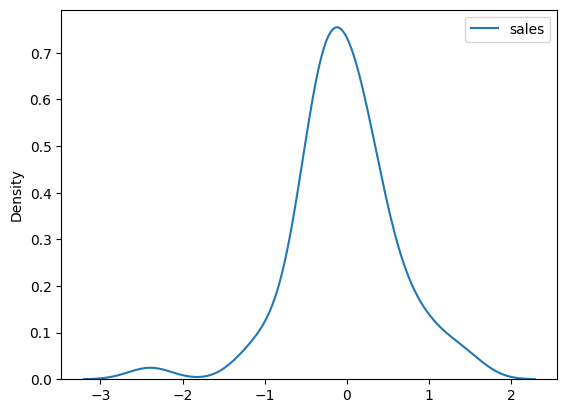

In [63]:
 sns.kdeplot(test_residuals);

In [64]:
elastic_model.l1_ratio_

np.float64(1.0)

- here the model is fully accepting Lasso as appropriate regularization.
- the `l1_ratio_` equals zero would be fully Ridge
- and the value in-between 0 and 1 would be the ratio of Rige and Lasso 

#### Since it is using all lasso, the `elastic_model` is performing same as the `lassocv_model` that I did earlier in this kernel, and the prediction for the campaign will be same

> For general use we don't need to choose between Lasso and ridge on our own. We can apply ElasticNetCV model which accepts range of l1_ratio (ranging from 0 to 1) based on which it chooses best regualrization or the ratio if needed

In [65]:
np.logspace(0, 10, num =10)

array([1.00000000e+00, 1.29154967e+01, 1.66810054e+02, 2.15443469e+03,
       2.78255940e+04, 3.59381366e+05, 4.64158883e+06, 5.99484250e+07,
       7.74263683e+08, 1.00000000e+10])